<a href="https://colab.research.google.com/github/DoggoWoofWoof/Implementation-of-GANS/blob/main/Sketch2Object%20Implementations/tensorflow_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, Model
from tensorflow.keras.layers import Input
from tqdm import tqdm
import time



!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xvf edges2shoes.tar.gz -C .
!mv edges2shoes data

Streaming output truncated to the last 5000 lines.
edges2shoes/train/46382_AB.jpg
edges2shoes/train/46383_AB.jpg
edges2shoes/train/46384_AB.jpg
edges2shoes/train/46385_AB.jpg
edges2shoes/train/46386_AB.jpg
edges2shoes/train/46387_AB.jpg
edges2shoes/train/46388_AB.jpg
edges2shoes/train/46389_AB.jpg
edges2shoes/train/4638_AB.jpg
edges2shoes/train/46390_AB.jpg
edges2shoes/train/46391_AB.jpg
edges2shoes/train/46392_AB.jpg
edges2shoes/train/449_AB.jpg
edges2shoes/train/44_AB.jpg
edges2shoes/train/45000_AB.jpg
edges2shoes/train/45001_AB.jpg
edges2shoes/train/45002_AB.jpg
edges2shoes/train/45003_AB.jpg
edges2shoes/train/45004_AB.jpg
edges2shoes/train/45005_AB.jpg
edges2shoes/train/45006_AB.jpg
edges2shoes/train/45007_AB.jpg
edges2shoes/train/45008_AB.jpg
edges2shoes/train/45009_AB.jpg
edges2shoes/train/4500_AB.jpg
edges2shoes/train/45010_AB.jpg
edges2shoes/train/45011_AB.jpg
edges2shoes/train/45012_AB.jpg
edges2shoes/train/45013_AB.jpg
edges2shoes/train/45687_AB.jpg
edges2shoes/train/45688_AB

In [ ]:
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
CHECKPOINT_DIR = "/checkpoints"
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
EPSILON = 1e-8
NUM_EPOCHS = 500
SAVE_MODEL = True

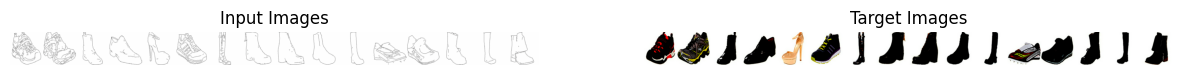

In [ ]:
# Preprocess input images (with augmentation)
def preprocess_input(image):
    # Resize the input image to 256x256 pixels
    image = tf.image.resize(image, [256, 256]).numpy()
    # Apply random horizontal flip
    image = np.fliplr(image)
    # Apply random brightness adjustment
    image = image + np.random.uniform(-0.2, 0.2, image.shape)
    # Normalize the image to the range [-1, 1]
    image = image / 127.5 - 1.0
    return image

# Preprocess target images (without augmentation)
def preprocess_target(image):
    # Resize the target image to 256x256 pixels
    image = tf.image.resize(image, [256, 256]).numpy()
    # Normalize the image to the range [-1, 1]
    image = image / 127.5 - 1.0
    return image

# Load and preprocess the images
def load_image(file_path):
    # Read the image file
    image = tf.io.read_file(file_path)
    # Decode the image as a 3-channel (RGB) image
    image = tf.image.decode_image(image, channels=3)
    # Convert the image tensor to a NumPy array
    image = image.numpy()
    # Split the image into input and target images
    w = image.shape[1] // 2
    input_image = preprocess_input(image[:, :w, :])
    target_image = preprocess_target(image[:, w:, :])
    # Convert the preprocessed images back to tensors
    return tf.convert_to_tensor(input_image, dtype=tf.float32), tf.convert_to_tensor(target_image, dtype=tf.float32)

# Create dataset
def get_dataset(root_dir, batch_size, shuffle=True):
    # List all image files in the directory
    list_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('jpg', 'png'))]
    # Create a TensorFlow dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices(list_files)
    if shuffle:
        # Shuffle the dataset if required
        dataset = dataset.shuffle(buffer_size=len(list_files))
    # Map the load_image function to each file path in the dataset
    dataset = dataset.map(lambda x: tf.numpy_function(load_image, [x], [tf.float32, tf.float32]),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # Batch the dataset
    return dataset.batch(batch_size)

# Display a batch of images
def display_batch(dataset):
    for input_images, target_images in dataset.take(1):
        # Concatenate input images for display
        concat_x = np.concatenate(input_images.numpy(), axis=1)
        # Concatenate target images for display
        concat_y = np.concatenate(target_images.numpy(), axis=1)

        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.imshow(concat_x)
        plt.title('Input Images')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(concat_y)
        plt.title('Target Images')
        plt.axis('off')

        plt.show()

# Example usage:
# Assuming TRAIN_DIR and VAL_DIR are defined, and BATCH_SIZE is set
train_dataset = get_dataset(TRAIN_DIR, BATCH_SIZE)
val_dataset = get_dataset(VAL_DIR, BATCH_SIZE, shuffle=False)

# Visualize the first batch of training data
display_batch(train_dataset)

In [ ]:
def cnn_block(out_channels, stride):
    return keras.Sequential([
        layers.ZeroPadding2D(1),
        layers.Conv2D(
            out_channels, 4, strides=stride, padding='valid', use_bias=False,
            kernel_initializer='he_normal'
        ),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2)
    ])

def discriminator(in_channels=3, features=[64, 128, 256, 512]):
    inputs = Input(shape=(None, None, in_channels * 2))

    # Initial layer
    x = layers.ZeroPadding2D(1)(inputs)
    x = layers.Conv2D(
        features[0], kernel_size=4, strides=2, padding='valid',
        kernel_initializer='he_normal'
    )(x)
    x = layers.LeakyReLU(0.2)(x)

    # Additional layers
    for feature in features[1:]:
        x = cnn_block(feature, stride=1 if feature == features[-1] else 2)(x)

    # Final layer
    x = layers.ZeroPadding2D(1)(x)
    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='valid')(x)

    return Model(inputs=inputs, outputs=outputs)

def test():
    x = tf.random.normal((1, 256, 256, 3))
    y = tf.random.normal((1, 256, 256, 3))
    model = discriminator(in_channels=3)

    # Concatenate inputs
    combined_input = tf.concat([x, y], axis=-1)

    preds = model(combined_input)
    model.summary()
    print(preds.shape)

test()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 6)]   0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, None, None, 6)     0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    6208      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 64)    0         
                                                                 
 sequential (Sequential)     (None, None, None, 128)   131584    
                                                                 
 sequential_1 (Sequential)   (None, None, None, 256)   525312    
                                                             

In [ ]:
def block(x, out_channels, down=True, act="relu", use_dropout=False):
    if down:
        x = layers.ZeroPadding2D(1)(x)
        x = layers.Conv2D(out_channels, 4, 2, padding='valid', use_bias=False)(x)
    else:
        x = layers.Conv2DTranspose(out_channels, 4, 2, padding='same', use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) if act == "relu" else layers.LeakyReLU(0.2)(x)

    if use_dropout:
        x = layers.Dropout(0.5)(x)

    return x

def generator(in_channels=3, features=64):
    inputs = Input(shape=(None, None, in_channels))

    # Downsampling
    d1 = layers.ZeroPadding2D(1)(inputs)
    d1 = layers.Conv2D(features, 4, 2, padding='valid')(d1)
    d1 = layers.LeakyReLU(0.2)(d1)

    d2 = block(d1, features * 2, down=True, act="leaky", use_dropout=False)
    d3 = block(d2, features * 4, down=True, act="leaky", use_dropout=False)
    d4 = block(d3, features * 8, down=True, act="leaky", use_dropout=False)
    d5 = block(d4, features * 8, down=True, act="leaky", use_dropout=False)
    d6 = block(d5, features * 8, down=True, act="leaky", use_dropout=False)
    d7 = block(d6, features * 8, down=True, act="leaky", use_dropout=False)

    # Bottleneck
    bottleneck = layers.ZeroPadding2D(1)(d7)
    bottleneck = layers.Conv2D(features * 8, 4, 2, padding='valid')(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)

    # Upsampling
    up1 = block(bottleneck, features * 8, down=False, act="relu", use_dropout=True)
    up2 = block(layers.Concatenate()([up1, d7]), features * 8, down=False, act="relu", use_dropout=True)
    up3 = block(layers.Concatenate()([up2, d6]), features * 8, down=False, act="relu", use_dropout=True)
    up4 = block(layers.Concatenate()([up3, d5]), features * 8, down=False, act="relu", use_dropout=False)
    up5 = block(layers.Concatenate()([up4, d4]), features * 4, down=False, act="relu", use_dropout=False)
    up6 = block(layers.Concatenate()([up5, d3]), features * 2, down=False, act="relu", use_dropout=False)
    up7 = block(layers.Concatenate()([up6, d2]), features, down=False, act="relu", use_dropout=False)

    # Final layer
    final = layers.Conv2DTranspose(in_channels, 4, 2, padding='same', activation='tanh')(layers.Concatenate()([up7, d1]))
    outputs = tf.keras.layers.Activation('linear', dtype='float32')(final)  # Ensure float32 output
    return Model(inputs=inputs, outputs=outputs)

def test():
    x = tf.random.normal((1, 256, 256, 3))
    model = generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

test()

(1, 256, 256, 3)


In [ ]:
def save_some_examples(gen, val_dataset, epoch, folder):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    for x, y in val_dataset.take(1):
        break

    gen.trainable = False
    y_fake = gen(x)
    gen.trainable = True

    # Convert to float32 and denormalize
    y_fake = tf.cast(y_fake, tf.float32) * 0.5 + 0.5
    x = tf.cast(x, tf.float32) * 0.5 + 0.5
    y = tf.cast(y, tf.float32) * 0.5 + 0.5

    # Clip values to [0, 1] range
    y_fake = tf.clip_by_value(y_fake, 0, 1)
    x = tf.clip_by_value(x, 0, 1)
    y = tf.clip_by_value(y, 0, 1)

    def save_image(img, path):
        plt.figure(figsize=(10, 10))
        # Convert to numpy array and squeeze
        img_np = tf.squeeze(img).numpy()
        plt.imshow(img_np)
        plt.axis('off')
        plt.savefig(path)
        plt.close()

    save_image(y_fake[0], os.path.join(folder, f"y_gen_{epoch}.png"))
    save_image(x[0], os.path.join(folder, f"input_{epoch}.png"))
    if epoch == 1:
        save_image(y[0], os.path.join(folder, f"label_{epoch}.png"))

def save_checkpoint(gen, disc, opt_gen, opt_disc, epoch, checkpoint_dir):
    print(f"=> Saving checkpoint for epoch {epoch}")

    # Creating a checkpoint for both generator and discriminator
    checkpoint = tf.train.Checkpoint(
        generator=gen,
        discriminator=disc,
        generator_optimizer=opt_gen,
        discriminator_optimizer=opt_disc,
        epoch=tf.Variable(epoch)
    )

    manager = tf.train.CheckpointManager(
        checkpoint, directory=checkpoint_dir,
        max_to_keep=None,  # No limit on the number of checkpoints
        checkpoint_name=f'checkpoint_epoch_{epoch}'
    )
    manager.save()

def load_generator_checkpoint(checkpoint_path, gen):
    print(f"=> Loading checkpoint from {checkpoint_path}")
    checkpoint = tf.train.Checkpoint(generator=gen)
    status = checkpoint.restore(checkpoint_path)
    status.assert_existing_objects_matched()
    print(f"Loaded generator checkpoint: {checkpoint_path}")

def load_discriminator_checkpoint(checkpoint_path, disc):
    print(f"=> Loading checkpoint from {checkpoint_path}")
    checkpoint = tf.train.Checkpoint(discriminator=disc)
    status = checkpoint.restore(checkpoint_path)
    status.assert_existing_objects_matched()
    print(f"Loaded discriminator checkpoint: {checkpoint_path}")

In [ ]:
# Helper functions
@tf.function(reduce_retracing=True)
def train_step(disc, gen, x, y, bce, l1_loss):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        y_fake = gen(x, training=True)

        D_real = disc(tf.concat([x, y], axis=-1), training=True)
        D_fake = disc(tf.concat([x, y_fake], axis=-1), training=True)

        D_real_loss = bce(tf.ones_like(D_real), D_real)
        D_fake_loss = bce(tf.zeros_like(D_fake), D_fake)
        D_loss = (D_real_loss + D_fake_loss) / 2

        G_fake_loss = bce(tf.ones_like(D_fake), D_fake)
        L1 = l1_loss(y_fake, y) * tf.constant(L1_LAMBDA, dtype=tf.float32)
        G_loss = G_fake_loss + L1

    gen_grads = gen_tape.gradient(G_loss, gen.trainable_variables)
    disc_grads = disc_tape.gradient(D_loss, disc.trainable_variables)

    return D_loss, G_loss, gen_grads, disc_grads

def train_fn(disc, gen, dataset, opt_disc, opt_gen, bce, l1_loss):
    loop = tqdm(dataset)

    for x, y in loop:
        D_loss, G_loss, gen_grads, disc_grads = train_step(disc, gen, x, y, bce, l1_loss)

        opt_disc.apply_gradients(zip(disc_grads, disc.trainable_variables))
        opt_gen.apply_gradients(zip(gen_grads, gen.trainable_variables))

        loop.set_postfix(D_loss=D_loss.numpy(), G_loss=G_loss.numpy())

def main():
    with tf.device(DEVICE):
        # Define your models here
        disc = discriminator(in_channels=3)
        gen = generator(in_channels=3, features=64)

        opt_disc = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.999)
        opt_gen = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.999)

        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        l1_loss = tf.keras.losses.MeanAbsoluteError()

        start_epoch = 0

        train_dataset = get_dataset(TRAIN_DIR, BATCH_SIZE, shuffle=True)
        val_dataset = get_dataset(VAL_DIR, batch_size=1, shuffle=False)

        for epoch in range(start_epoch, NUM_EPOCHS):
            train_fn(disc, gen, train_dataset, opt_disc, opt_gen, bce, l1_loss)

            if SAVE_MODEL and (epoch + 1) % 1 == 0:
                save_checkpoint(gen, disc, opt_gen, opt_disc, epoch + 1, CHECKPOINT_DIR)

            save_some_examples(gen, val_dataset, epoch, folder="evaluation")

            print(f"Epoch {epoch + 1}/{NUM_EPOCHS} completed")


main()

100%|██████████| 3115/3115 [37:16<00:00,  1.39it/s, D_loss=0.407, G_loss=24]


=> Saving checkpoint for epoch 1
Epoch 1/500 completed


 60%|██████    | 1884/3115 [22:13<14:31,  1.41it/s, D_loss=0.388, G_loss=15.8]


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to generate image using the generator model
def generate_image(generator, input_image):
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    generated_image = generator(input_image, training=False)
    generated_image = tf.squeeze(generated_image, axis=0)  # Remove batch dimension
    return generated_image

# Function to test the checkpoint and display images
def test_checkpoint(test_image_path, checkpoint_path):
    # Define your generator architecture (replace with your actual generator definition)
    gen = generator(in_channels=3, features=64)

    # Load the specified checkpoint
    load_generator_checkpoint(checkpoint_path, gen)

    # Load and preprocess the test image
    input_image, _ = load_image(test_image_path)

    # Generate the image
    generated_image = generate_image(gen, input_image)

    # Convert images from tensors to numpy arrays and denormalize
    input_image = input_image.numpy() * 0.5 + 0.5
    generated_image = generated_image.numpy() * 0.5 + 0.5

    # Display the input and generated images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    ax1.imshow(input_image)
    ax1.set_title("Input Image")
    ax1.axis("off")

    ax2.imshow(generated_image)
    ax2.set_title("Generated Image")
    ax2.axis("off")

    # Adjust layout to prevent clipping
    plt.tight_layout()

    plt.show()

TEST_IMAGE_PATH = "/image.png"  # Replace with your actual test image path
CHECKPOINT_PATH = "/checkpoints/checkpoint_epoch_1-1"  # Replace with your actual checkpoint path

test_checkpoint(TEST_IMAGE_PATH, CHECKPOINT_PATH)


=> Loading checkpoint from /checkpoints/checkpoint_epoch_1-1


Loaded generator checkpoint: /checkpoints/checkpoint_epoch_1-1
